
--- Training ResNet18 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipython-input-11-1420102230.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-11-1420102230.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-11-1420102230.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `t

Epoch 1/10: Train Loss 0.7641 Acc 0.7320 | Val Loss 1.0182 Acc 0.6802
Epoch 2/10: Train Loss 0.4904 Acc 0.8312 | Val Loss 0.7015 Acc 0.7867
Epoch 3/10: Train Loss 0.3775 Acc 0.8685 | Val Loss 0.3596 Acc 0.8769
Epoch 4/10: Train Loss 0.2902 Acc 0.8997 | Val Loss 0.4309 Acc 0.8456
Epoch 5/10: Train Loss 0.2359 Acc 0.9186 | Val Loss 0.4430 Acc 0.8585
Epoch 6/10: Train Loss 0.1979 Acc 0.9310 | Val Loss 0.4466 Acc 0.8604
Epoch 7/10: Train Loss 0.1590 Acc 0.9469 | Val Loss 0.5053 Acc 0.8298
Epoch 8/10: Train Loss 0.1313 Acc 0.9577 | Val Loss 0.4268 Acc 0.8709
Epoch 9/10: Train Loss 0.1158 Acc 0.9604 | Val Loss 0.2190 Acc 0.9333
Epoch 10/10: Train Loss 0.0839 Acc 0.9720 | Val Loss 0.2912 Acc 0.8948
Zapisano model: resnet18_eurosat.pth

--- Training ViT-B/16 ---
Epoch 1/10: Train Loss 1.0902 Acc 0.6051 | Val Loss 0.6189 Acc 0.7713
Epoch 2/10: Train Loss 0.5831 Acc 0.7913 | Val Loss 0.6135 Acc 0.7798
Epoch 3/10: Train Loss 0.4663 Acc 0.8365 | Val Loss 0.4268 Acc 0.8541
Epoch 4/10: Train Loss 0.

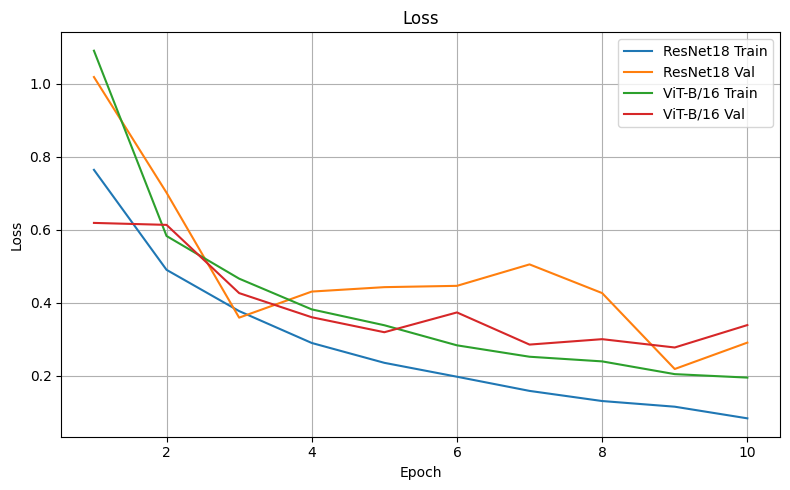

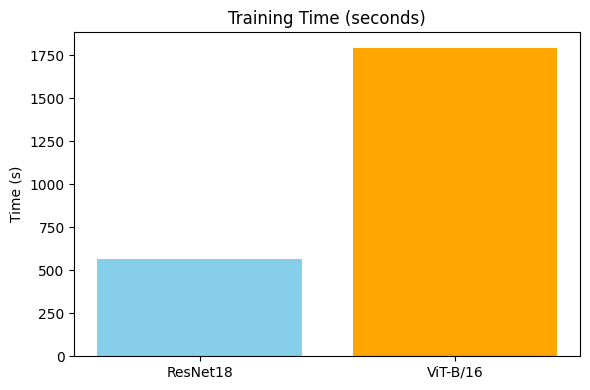

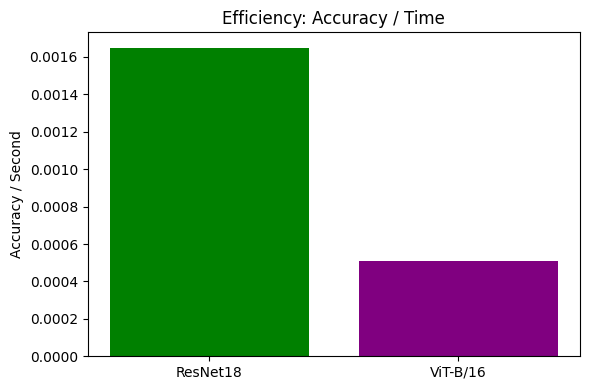

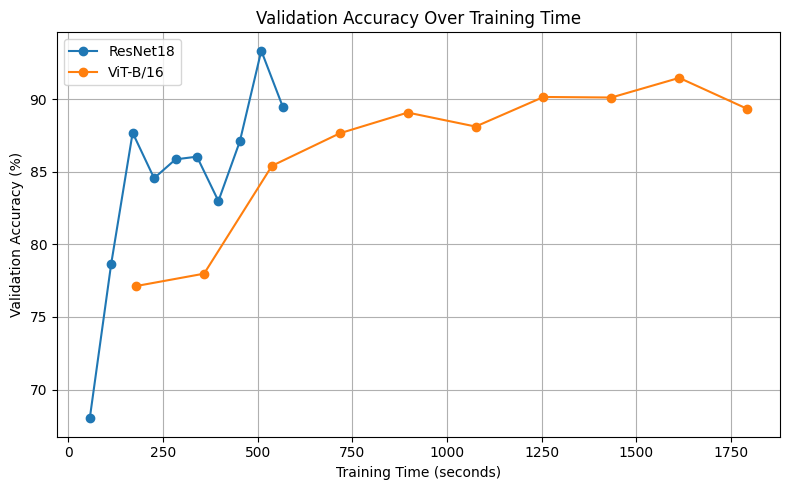

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import timm
import time
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

# Parametry
BATCH_SIZE = 64
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
torch.backends.cudnn.benchmark = True

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dane
data_train = datasets.EuroSAT(root="./data", download=True, transform=transform)
train_size = int(0.8 * len(data_train))
val_size = len(data_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

# Funkcja trenowania
def train_model(model, criterion, optimizer, num_epochs, model_name):
    model.to(DEVICE)
    scaler = GradScaler()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss_epoch = val_loss / len(val_dataset)
        val_acc_epoch = val_correct.double() / len(val_dataset)
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc_epoch.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f} Acc {epoch_acc:.4f} | Val Loss {val_loss_epoch:.4f} Acc {val_acc_epoch:.4f}")

    total_time = time.time() - start_time
    torch.save(model.state_dict(), f"{model_name}_eurosat.pth")
    print(f"Zapisano model: {model_name}_eurosat.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# ResNet18
print("\n--- Training ResNet18 ---")
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASSES)
for param in resnet_model.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc, resnet_time = train_model(
    resnet_model, criterion, optimizer, EPOCHS, "resnet18"
)

# ViT-B/16
print("\n--- Training ViT-B/16 ---")
vit_model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=NUM_CLASSES)
for param in vit_model.parameters():
    param.requires_grad = True
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-4)

vit_train_loss, vit_val_loss, vit_train_acc, vit_val_acc, vit_time = train_model(
    vit_model, criterion_vit, optimizer_vit, EPOCHS, "vit_b16"
)

# Loss Plot
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, resnet_train_loss, label='ResNet18 Train')
plt.plot(epochs, resnet_val_loss, label='ResNet18 Val')
plt.plot(epochs, vit_train_loss, label='ViT-B/16 Train')
plt.plot(epochs, vit_val_loss, label='ViT-B/16 Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("training_comparison.png")
plt.show()

# Training Time Plot
plt.figure(figsize=(6, 4))
plt.bar(["ResNet18", "ViT-B/16"], [resnet_time, vit_time], color=["skyblue", "orange"])
plt.title("Training Time (seconds)")
plt.ylabel("Time (s)")
plt.tight_layout()
plt.savefig("training_time.png")
plt.show()

# Efficiency Plot
eff_resnet = max(resnet_val_acc) / resnet_time
eff_vit = max(vit_val_acc) / vit_time
plt.figure(figsize=(6, 4))
plt.bar(["ResNet18", "ViT-B/16"], [eff_resnet, eff_vit], color=["green", "purple"])
plt.title("Efficiency: Accuracy / Time")
plt.ylabel("Accuracy / Second")
plt.tight_layout()
plt.savefig("efficiency.png")
plt.show()

# Validation Accuracy Over Time Plot
resnet_time_per_epoch = resnet_time / EPOCHS
vit_time_per_epoch = vit_time / EPOCHS

resnet_time_axis = [resnet_time_per_epoch * (i + 1) for i in range(EPOCHS)]
vit_time_axis = [vit_time_per_epoch * (i + 1) for i in range(EPOCHS)]

plt.figure(figsize=(8, 5))
plt.plot(resnet_time_axis, [acc * 100 for acc in resnet_val_acc], label="ResNet18", marker='o')
plt.plot(vit_time_axis, [acc * 100 for acc in vit_val_acc], label="ViT-B/16", marker='o')
plt.xlabel("Training Time (seconds)")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over Training Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("val_acc_over_time.png")
plt.show()




=== Predykcje ResNet18 ===

Poprawne predykcje:


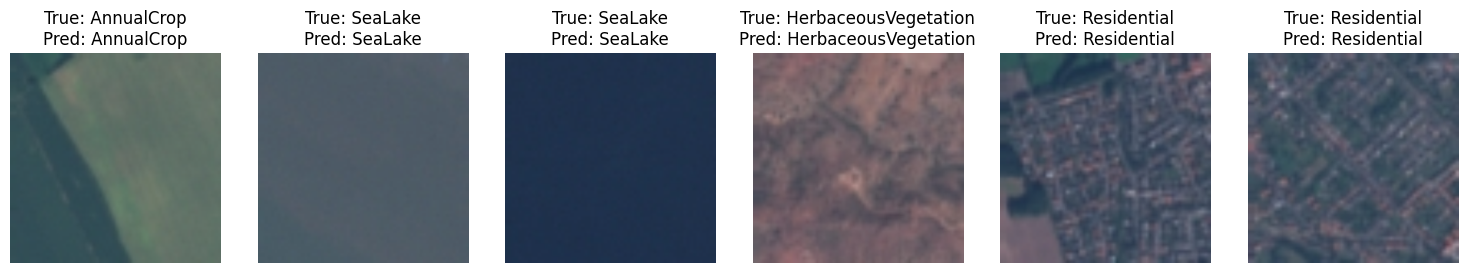


Błędne predykcje:


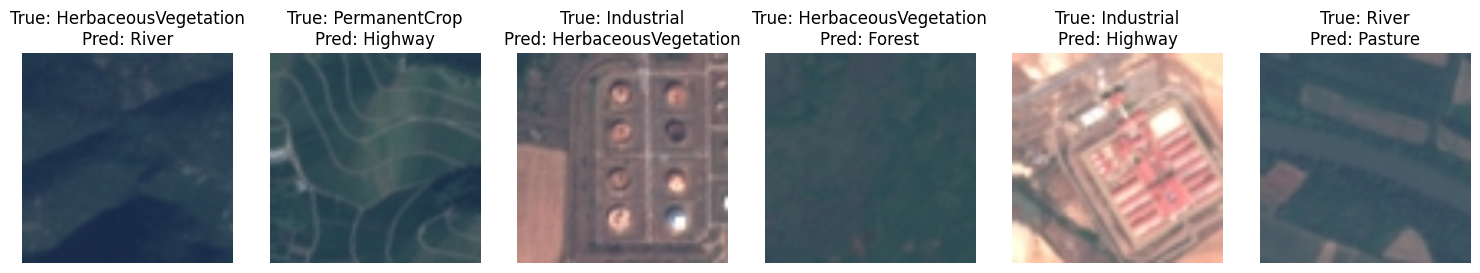


=== Predykcje ViT-B/16 ===

Poprawne predykcje:


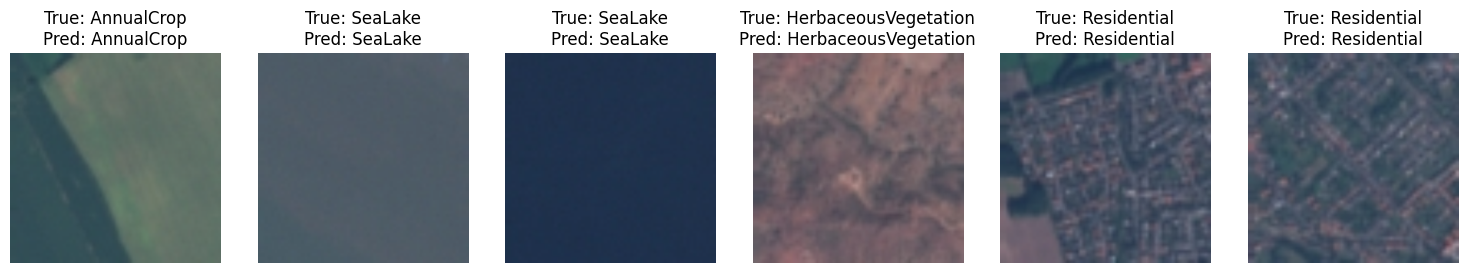


Błędne predykcje:


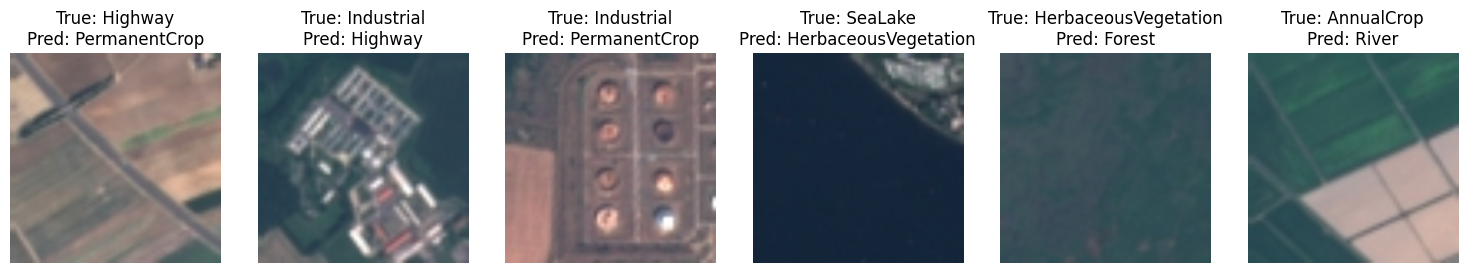

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def show_predictions(model, dataset, class_names, num_samples=6):
    model.eval()
    model.to(DEVICE)
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for i in range(len(dataset)):
            image, label = dataset[i]
            input_tensor = image.unsqueeze(0).to(DEVICE)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            if pred.item() == label:
                correct_samples.append((image, label, pred.item()))
            else:
                incorrect_samples.append((image, label, pred.item()))

            if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                break

    print("\nPoprawne predykcje:")
    plt.figure(figsize=(15, 5))
    for idx, (img, true, pred) in enumerate(correct_samples[:num_samples]):
        plt.subplot(2, num_samples, idx + 1)
        imshow(img, title=f"True: {class_names[true]}\nPred: {class_names[pred]}")
    plt.tight_layout()
    plt.show()

    print("\nBłędne predykcje:")
    plt.figure(figsize=(15, 5))
    for idx, (img, true, pred) in enumerate(incorrect_samples[:num_samples]):
        plt.subplot(2, num_samples, idx + 1)
        imshow(img, title=f"True: {class_names[true]}\nPred: {class_names[pred]}")
    plt.tight_layout()
    plt.show()

class_names = data_train.classes

print("\n=== Predykcje ResNet18 ===")
show_predictions(resnet_model, val_dataset, class_names)

print("\n=== Predykcje ViT-B/16 ===")
show_predictions(vit_model, val_dataset, class_names)


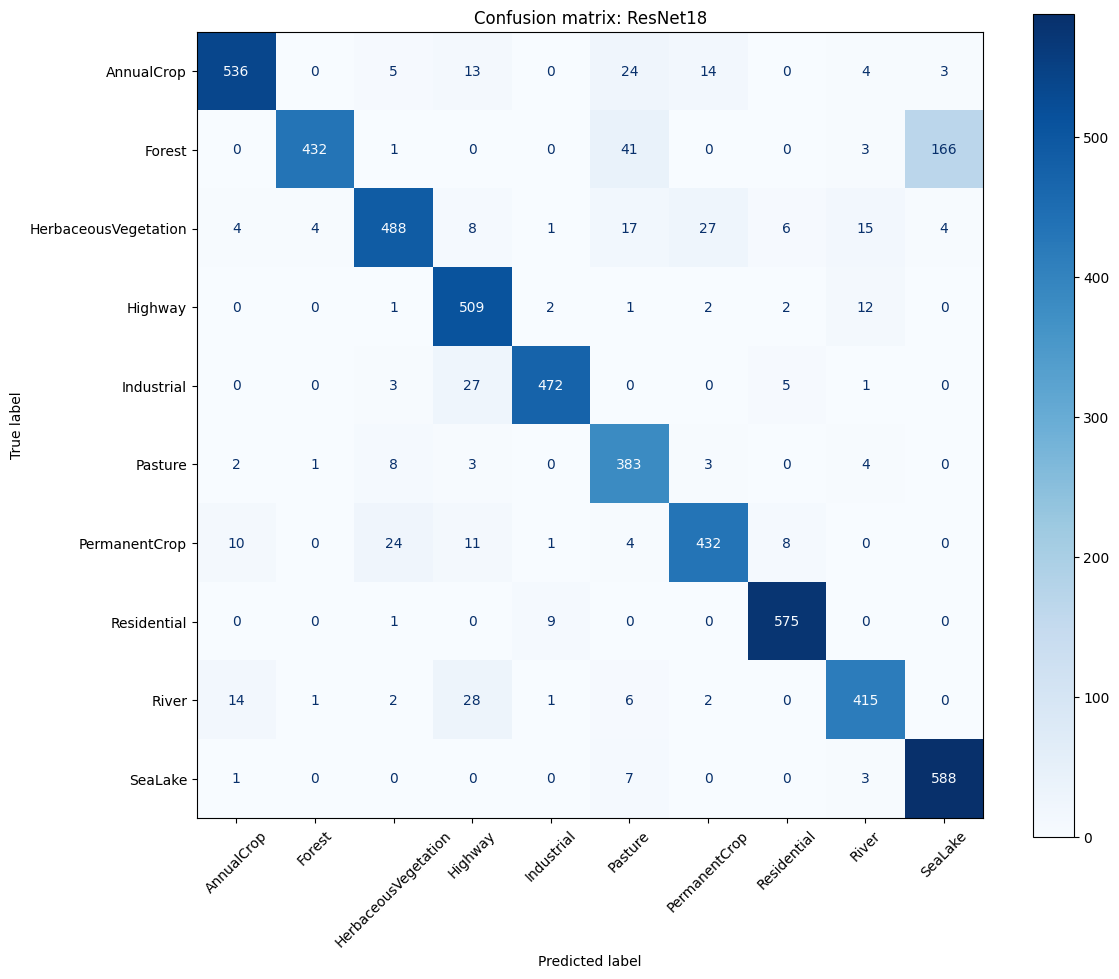

In [13]:
def plot_confusion(model, dataset, class_names, model_name):
    model.eval()
    model.to(DEVICE)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in DataLoader(dataset, batch_size=64):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(
        ax=ax,
        xticks_rotation=45,
        cmap='Blues',
        values_format='d',
        colorbar=True
    )
    plt.title(f"Confusion matrix: {model_name}")
    plt.tight_layout()
    safe_model_name = model_name.replace("/", "_").replace(" ", "_").lower()
    plt.savefig(f"confusion_matrix_{safe_model_name}.png")
    plt.show()
class_names = data_train.classes

plot_confusion(resnet_model, val_dataset, class_names, "ResNet18")

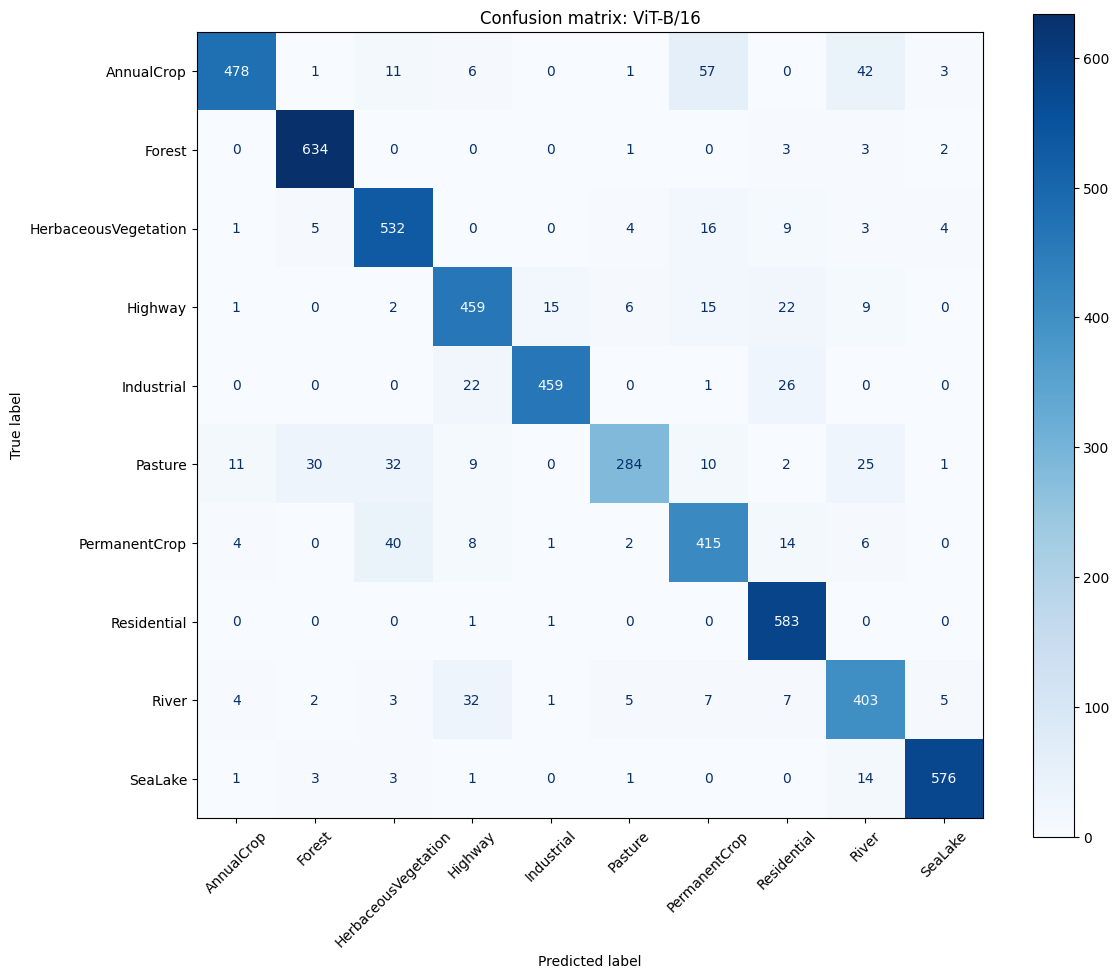

In [14]:
plot_confusion(vit_model, val_dataset, class_names, "ViT-B/16")

In [15]:
import torch
import psutil
import platform
import subprocess

def get_gpu_info():
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        cuda_version = torch.version.cuda
        return gpu_name, cuda_version
    return "No GPU", "N/A"

def get_cpu_info():
    try:
        cpu_info = subprocess.check_output("lscpu", shell=True).decode()
        for line in cpu_info.split("\n"):
            if "Model name" in line:
                return line.split(":")[1].strip()
    except:
        return platform.processor()
    return "Unknown"

def get_ram_info():
    ram_bytes = psutil.virtual_memory().total
    ram_gb = round(ram_bytes / (1024 ** 3), 2)
    return f"{ram_gb} GB"

cpu = get_cpu_info()
ram = get_ram_info()
gpu, cuda = get_gpu_info()

print("=== Hardware Setup ===")
print(f"CPU:  {cpu}")
print(f"RAM:  {ram}")
print(f"GPU:  {gpu}")
print(f"CUDA: {cuda}")


=== Hardware Setup ===
CPU:  Intel(R) Xeon(R) CPU @ 2.00GHz
RAM:  12.67 GB
GPU:  Tesla T4
CUDA: 12.4
